# HOMEWORK 1
Shanice Bailey

03-16-2020

# Problem 1
**Re-derive the barotropic vorticity budget for a non-flat ocean bottom.**

1) **We start with the Planetary geostrophic momentum equation:**
$$
\frac{\partial \textbf{u}}{\partial t} + \textbf{f} \times \textbf{u} = -\nabla_z \phi + \frac{\partial \pmb{\tau}}{\partial z}
$$
We first derive the vorticity equation by taking the curl ($\hat{k} \cdot\nabla \times$) component-wise:
$$
[\frac{\partial u}{\partial t} - fv = - \frac{\partial \phi}{\partial x} + \frac{\partial \mathbf{\tau^x}}{\partial z}](-\frac{\partial}{\partial y})
$$
$$
[\frac{\partial v}{\partial t} + fu = - \frac{\partial \phi}{\partial y} + \frac{\partial \mathbf{\tau^y}}{\partial z}](\frac{\partial}{\partial x})
$$
$$
=> \frac{\partial \zeta}{\partial t} + \frac{\partial (fv)}{\partial y} + \frac{\partial (fu)}{\partial x} = -\frac{\partial}{\partial y}(\frac{\partial \mathbf{\tau^x}}{\partial z}) + \frac{\partial}{\partial x}(\frac{\partial \mathbf{\tau^y}}{\partial z})
$$
Compacting the equation (and assuming steady-state so $\frac{\partial \zeta}{\partial t} = 0$), we arrive at the form:
$$
\boxed{\beta v - f \frac{\partial w}{\partial z} = curl(\frac{\partial \pmb{\tau}}{\partial z})}
$$

2) **We then vertically integrate the equation above**
$$
\int^\eta_{\eta_B} [\beta v - f \frac{\partial w}{\partial z} = curl(\frac{\partial \pmb{\tau}}{\partial z})]\ dz
$$

• 1st term: 
$$
\int^\eta_{\eta_B} \beta v\ dz = \beta \int^\eta_{\eta_B} v\ dz 
$$

$$
=> \beta v z\ \big|^\eta_{\eta_B} = \beta v \eta - \beta v \eta_B 
$$

$$
=> \boxed{\beta v (\eta - \eta_B) = \beta V}
$$

• 2nd term:
$$
- \int^\eta_{\eta_B} f \frac{\partial w}{\partial z}\ dz = \int^\eta_{\eta_B} f\ \nabla \cdot \textbf{u}\ dz
$$

$$
=> f\ \nabla \cdot \int^\eta_{\eta_B} \textbf{u}\ dz = f\ \nabla \cdot (\textbf{u} z)\ \big|^\eta_{\eta_B}
$$

$$
=> f\ \nabla \cdot (\textbf{u} \eta) - f\ \nabla \cdot (\textbf{u} \eta_B)
$$
first term is zero since we assume no flux across ocean surface
$$
=> -f\ [\textbf{u} \nabla \cdot \eta_B + \eta_B \nabla \cdot \textbf{u}]
$$
second term is zero due to continuity equation, therefore,
$$
\boxed{-f\ \textbf{u} \nabla \cdot \eta_B}
$$

• 3rd term:
$$
\int^\eta_{\eta_B} curl(\frac{\partial \pmb{\tau}}{\partial z})\ dz = curl \int^\eta_{\eta_B} \frac{\partial \pmb{\tau}}{\partial z}\ dz
$$

$$
=> \boxed{curl(\pmb{\tau_s}) - curl(\pmb{\tau_b})}
$$

3) **Putting it all together we arrive at the Barotropic vorticity equation with a non-flat bottom:**
$$
\boxed{\beta V - f\ \textbf{u} \nabla \cdot \eta_B = curl(\pmb{\tau_s}) - curl(\pmb{\tau_b})}
$$

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import hvplot.xarray
import xmitgcm
xmitgcm.file_utils.clear_cache()

In [4]:
rundir = '/rigel/ocp/users/stb2145/tutorial_barotropic_gyre/run'
ds = xmitgcm.open_mdsdataset(rundir, iters=72*np.arange(1,201),
                             delta_t=1200, calendar='360_day', ref_date='0000-01-01 00:00:00')

/rigel/ocp/projects/conda/envs/pangeo2020/lib/python3.7/site-packages/xmitgcm/mds_store.py:236: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  ds = xr.auto_combine(datasets)
/rigel/ocp/projects/conda/envs/pangeo2020/lib/python3.7/site-packages/xmitgcm/mds_store.py:236: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
op

In [5]:
coords = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)
ds

<xarray.Dataset>
Dimensions:   (XC: 62, XG: 62, YC: 62, YG: 62, Z: 1, Zl: 1, Zp1: 2, Zu: 1, time: 200)
Coordinates:
  * XC        (XC) >f4 -10000.0 10000.0 30000.0 ... 1190000.0 1210000.0
  * YC        (YC) >f4 -10000.0 10000.0 30000.0 ... 1190000.0 1210000.0
  * XG        (XG) >f4 -20000.0 0.0 20000.0 ... 1160000.0 1180000.0 1200000.0
  * YG        (YG) >f4 -20000.0 0.0 20000.0 ... 1160000.0 1180000.0 1200000.0
  * Z         (Z) >f4 -2500.0
  * Zp1       (Zp1) >f4 0.0 -5000.0
  * Zu        (Zu) >f4 -5000.0
  * Zl        (Zl) >f4 0.0
  * time      (time) object 0000-01-02 00:00:00 ... 0000-07-21 00:00:00
Data variables:
    PH        (time, YC, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    Eta       (time, YC, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    T         (time, YC, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    W         (time, YC, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    PHL       (time, YC, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    U         (time, YC, XG) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    V         (time, YG, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    USidDrag  (time, YC, XG) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    VSidDrag  (time, YG, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    Um_Diss   (time, YC, XG) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    Vm_Diss   (time, YG, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    Um_ImplD  (time, YC, XG) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    Vm_ImplD  (time, YG, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    Um_Advec  (time, YC, XG) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    Vm_Advec  (time, YG, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    Um_Cori   (time, YC, XG) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    Vm_Cori   (time, YG, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    Um_dPhiX  (time, YC, XG) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    Vm_dPhiY  (time, YG, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    Um_Ext    (time, YC, XG) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    Vm_Ext    (time, YG, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    botTauX   (time, YC, XG) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    botTauY   (time, YG, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>
    S         (time, YC, XC) float32 dask.array<chunksize=(1, 62, 62), meta=np.ndarray>

In [6]:
import xgcm
metrics = {
    ('X',): ['dxC', 'dxG'],
    ('Y',): ['dyC', 'dyG'],
    ('Z',): ['drC', 'drF'],
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw']
}

grid = xgcm.Grid(coords, metrics=metrics, periodic=True)
grid

<xgcm.Grid>
T Axis (periodic):
  * center   time
Y Axis (periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
Z Axis (periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center

In [7]:
U_center = grid.interp(ds.U, 'X', boundary='fill')
V_center = grid.interp(ds.V, 'Y', boundary='fill')

# Problem 2
Calculate the Stommel solution in the MITgcm tutorial_barotropic_gyre simulation and compare it to the full solution. Use the standard wind stress (0.1 N/m^2)  and also a double-strength wind stress (0.2 N/m^2). You will have to figure out how to write an appropriately formatted binary file.

## • MITgcm's full solution
$$
\psi = - \int_0^y dy' \int_{-H}^0 dz u(x,y',z,t)
$$

In [11]:
ψ = -grid.cumint(ds.U * coords.drF[0], 'Y', boundary='fill')/1e6
ψ

<xarray.DataArray 'concatenate-9875394b7b7661dd7779916ee132c790' (time: 200, YG: 62, XG: 62)>
dask.array<truediv, shape=(200, 62, 62), dtype=float32, chunksize=(1, 61, 62), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0000-01-02 00:00:00 ... 0000-07-21 00:00:00
  * YG       (YG) >f4 -20000.0 0.0 20000.0 ... 1160000.0 1180000.0 1200000.0
  * XG       (XG) >f4 -20000.0 0.0 20000.0 ... 1160000.0 1180000.0 1200000.0

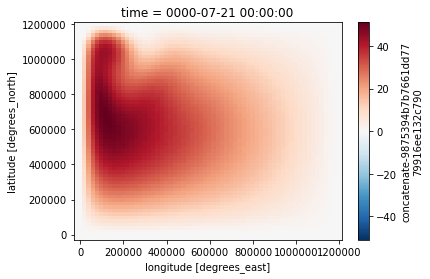

In [12]:
ψ[-1].plot()

In [22]:
#function to take the curl(var)
def curl(u, v):
    return(-grid.diff(u * coords.dxC, 'Y', boundary='extend') +
           grid.diff(v * coords.dyC, 'X', boundary='extend')) / coords.rAz

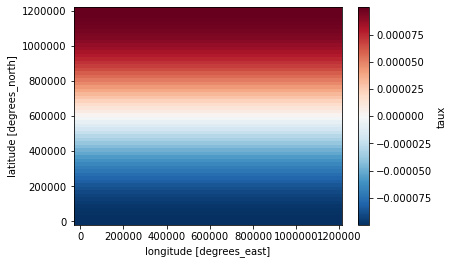

In [13]:
#read windstress
dtype = '>f4'
taux_data = np.fromfile(f'{rundir}/windx_cosy.bin', dtype=dtype)
taux_data.shape = coords.rA.shape
rho0 = 1000.
ds['taux'] = ('YC', 'XG'), taux_data / rho0
ds.taux.plot()

## • Stommel's solution:
$$
\Psi = \frac{\tau_0 \pi}{\beta}(1 - \frac{x}{a} - e^{-\frac{x}{a\epsilon}})sin(\frac{\pi y}{a})
$$

In [14]:
rho0 = 1000 #kg/m^3
tau_0 = 0.1 #N/m^2
beta = 1e-11 #(sm)^-1
r = 1e-6 #why is it to 1e-6??
a = coords.YG[-1].values
epsilon = r / (beta * a)
x = coords.XG
y = coords.YG

In [15]:
psi = ((tau_0*np.pi) / beta) * (1 - (x / a) - np.e**(- (x / (a*epsilon)))) * np.sin((np.pi*y) / a)
psi_2 = ((0.2*np.pi) / beta) * (1 - (x / a) - np.e**(- (x / (a*epsilon)))) * np.sin((np.pi*y) / a)

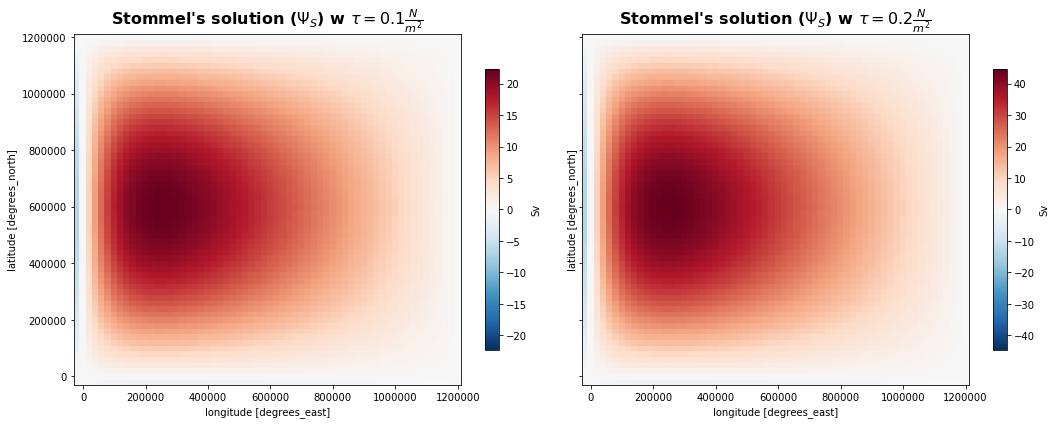

In [18]:
#Sv after dividing by rho0
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,6), sharey=True)

(psi/(rho0*1e6)).transpose().plot(cbar_kwargs={'shrink' : 0.8, 'label':'Sv'}, ax=ax0)
ax0.set_title(r"Stommel's solution ($\Psi_S$) w $\tau = 0.1 \frac{N}{m^2}$", fontsize=16, weight='bold')

(psi_2/(rho0*1e6)).transpose().plot(cbar_kwargs={'shrink' : 0.8, 'label':'Sv'}, ax=ax1)
ax1.set_title(r"Stommel's solution ($\Psi_S$) w $\tau = 0.2 \frac{N}{m^2}$", fontsize=16, weight='bold')
plt.tight_layout();

### Plotting difference between Full solution and Stommel's solution

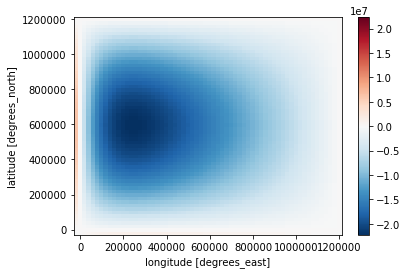

In [25]:
(full_sol - (psi/(rho0*1e6))).plot()

# Problem 3 
Diagnose all terms in the barotropic vorticity budget to the best of your ability. You may wish to use the extra diagnostics I have suggested in the github repo.
(Section taken from Ryan's repo on his GitHub: https://github.com/rabernat/ocean_dynamics/blob/master/momentum_vorticity_budget.ipynb)

## Zonal Momentum Budget

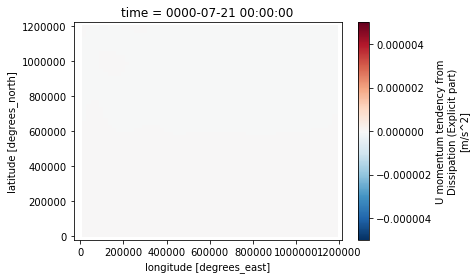

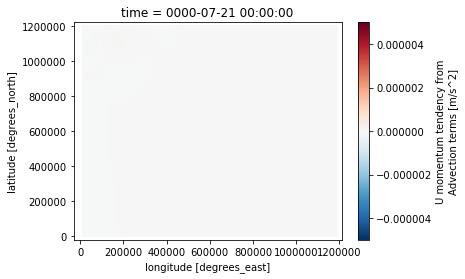

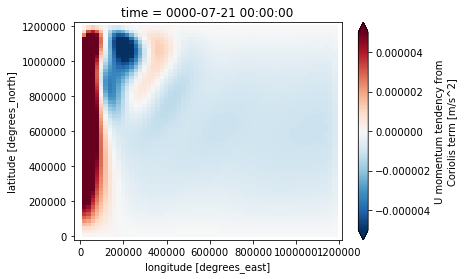

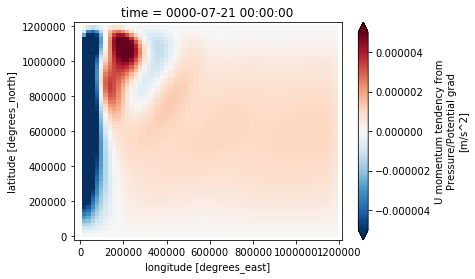

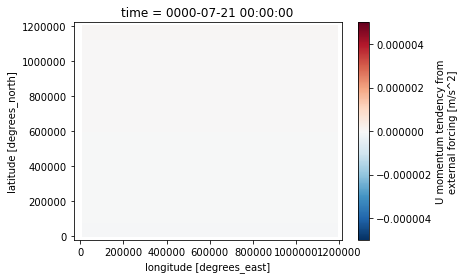

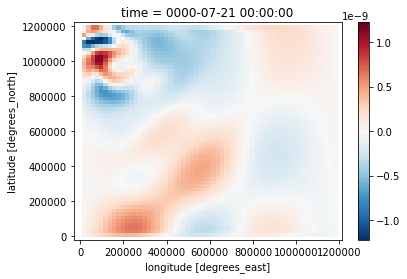

In [18]:
# http://mailman.mitgcm.org/pipermail/mitgcm-support/2010-December/006920.html
# > seem to be double counting with Um_Advec and Um_Cori
# > For vector invariant momentum formulation (not sure about flux 
# > form) Um_Advec includes coriolis

Um_advec_wo_coriolis = ds.Um_Advec - ds.Um_Cori
Um_advec_wo_coriolis.attrs.update(ds.Um_Advec.attrs)

names = ['Dissipation', 'Avection', 'Coriolis', 'Pressure Gradient', 'External Forcing']

terms_U = [ds.Um_Diss, Um_advec_wo_coriolis, ds.Um_Cori, ds.Um_dPhiX , ds.Um_Ext]
sum_terms_U = sum(terms_U)

vmax=5e-6


mask_u = coords.hFacW > 0.

for term in terms_U:
    data = term[-1].where(mask_u)
    plt.figure()
    data.plot(vmax=vmax)
    
    
plt.figure()
sum_terms_U[-1].where(mask_u).plot()

## Meridional Momentum Budget


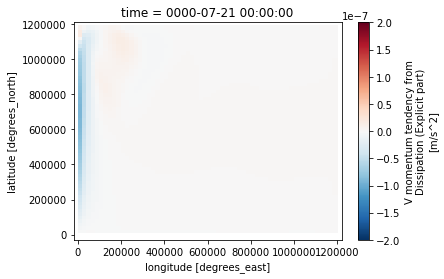

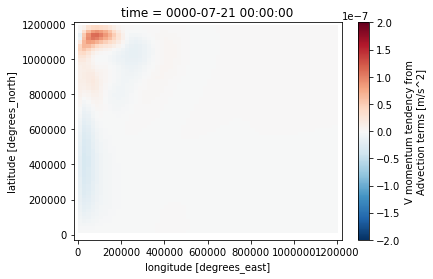

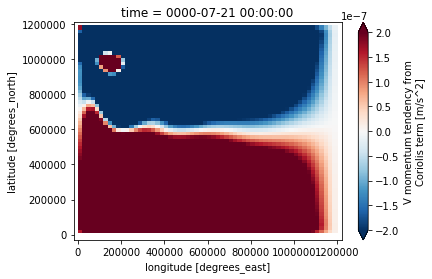

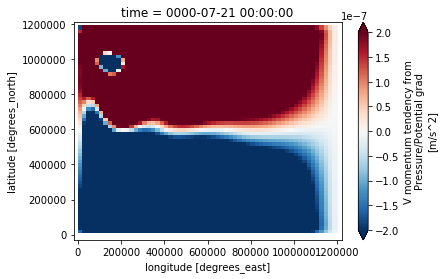

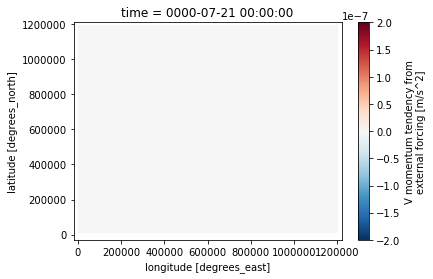

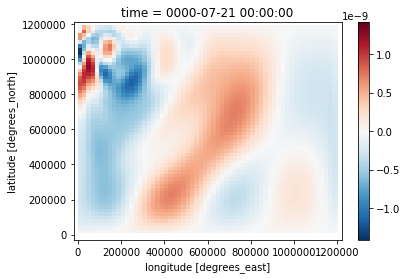

In [9]:
Vm_advec_wo_coriolis = ds.Vm_Advec - ds.Vm_Cori
Vm_advec_wo_coriolis.attrs.update(ds.Vm_Advec.attrs)

terms_V = [ds.Vm_Diss, Vm_advec_wo_coriolis, ds.Vm_Cori, ds.Vm_dPhiY , ds.Vm_Ext]
sum_terms_V = sum(terms_V)

vmax=2e-7

mask_v = coords.hFacS > 0.

for term in terms_V:
    plt.figure()
    term[-1].where(mask_v).plot(vmax=vmax, vmin=-vmax, cmap='RdBu_r')
    
plt.figure()
sum_terms_V[-1].where(mask_v).plot()

## Vorticity Budget

In [23]:
terms_curl = [curl(u, v) for u, v in zip(terms_U, terms_V)]

In [24]:
mask_z = ((1 - grid.interp(coords.hFacS, 'X', boundary='extend')) +
          (1 - grid.interp(coords.hFacW, 'Y', boundary='extend'))) < 1.
mask_z

<xarray.DataArray (YG: 62, XG: 62)>
dask.array<lt, shape=(62, 62), dtype=bool, chunksize=(61, 61), chunktype=numpy.ndarray>
Coordinates:
  * YG       (YG) >f4 -20000.0 0.0 20000.0 ... 1160000.0 1180000.0 1200000.0
  * XG       (XG) >f4 -20000.0 0.0 20000.0 ... 1160000.0 1180000.0 1200000.0

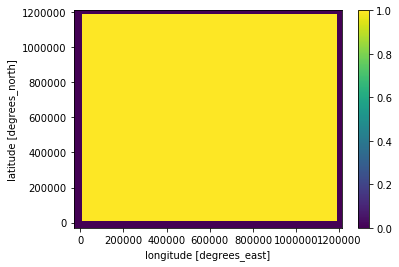

In [25]:
mask_z.plot()

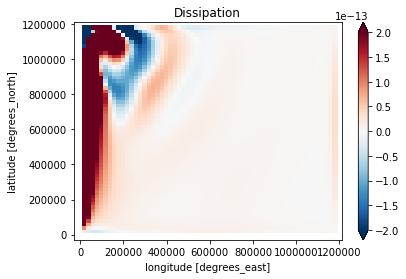

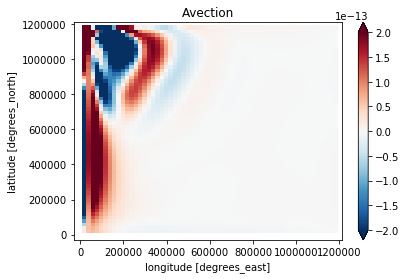

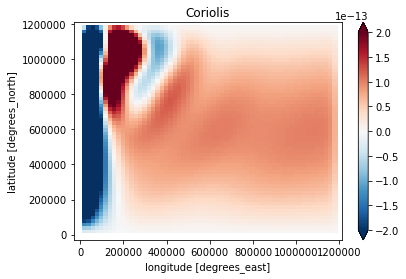

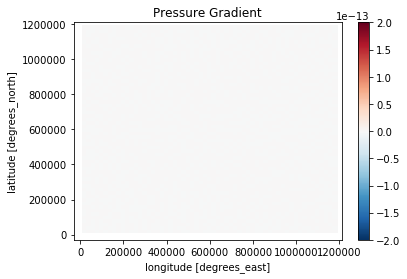

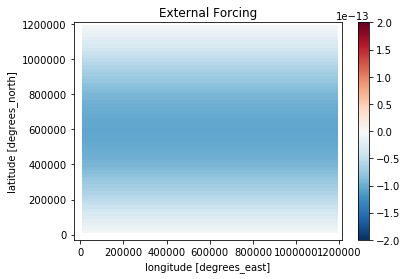

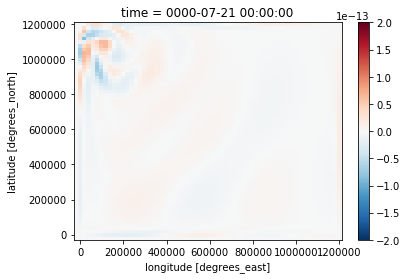

In [26]:
vmax=2e-13

for term, name in zip(terms_curl, names):
    plt.figure()
    term[-1].where(mask_z).plot(vmax=vmax)
    plt.title(name)
    
plt.figure()
sum(terms_curl)[-1].plot(vmax=vmax)

In [27]:
ds_vort = xr.merge([term.rename(name) for term, name in zip(terms_curl, names)])
ds_vort

<xarray.Dataset>
Dimensions:            (XG: 62, YG: 62, time: 200)
Coordinates:
  * time               (time) object 0000-01-02 00:00:00 ... 0000-07-21 00:00:00
  * YG                 (YG) >f4 -20000.0 0.0 20000.0 ... 1180000.0 1200000.0
  * XG                 (XG) >f4 -20000.0 0.0 20000.0 ... 1180000.0 1200000.0
Data variables:
    Dissipation        (time, YG, XG) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    Avection           (time, YG, XG) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    Coriolis           (time, YG, XG) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    Pressure Gradient  (time, YG, XG) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
    External Forcing   (time, YG, XG) float32 dask.array<chunksize=(1, 1, 1), meta=np.ndarray>

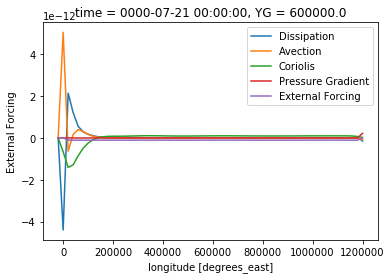

In [28]:
ds_to_plot = ds_vort.isel(time=-1).sel(YG=600000, method='nearest')

fig, ax = plt.subplots()
ax.set_facecolor('white')
for dvar in ds_to_plot:
    ds_to_plot[dvar].plot(label=dvar, ax=ax)
    
plt.legend()